# Notebook de cliente

In [1]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizerFast
from preprocess_dataset import remove_empty_entries

import torch

## Setups

In [2]:
CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT)

In [3]:
data = "lener_br"
dataset = load_dataset(data)
dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


In [4]:
MAX_LEN = 128
n_labels = 13 #TODO: por enquanto hardcodado 

In [5]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
teste = pytorch_dataset_train[0]

In [6]:
model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

----------------------------------------

## Treinando o modelo

Usando parametros padrão por enquanto só pra ver se ta tudo indo certindo

In [7]:
from trainner import Trainner, create_data_loader
from transformers import AdamW
from torch.utils.data import DataLoader
from evaluator import Evaluator

### Parametros


* batch sizes: 8, 16, 32, 64, 128
* learning rates: 3e-4, 1e-4, 5e-5, 3e-5

Do paper do BERT. Vou colocar num_workers = 4 por enquanto.


Uma melhoria é esconder o data_loader de clientes. Isso é detalhe de implementaçãõ, ou deveria estar na classe NERDataset

In [8]:
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

In [9]:
len(pytorch_dataset_train)

7827

In [10]:
loader = DataLoader(pytorch_dataset_train, batch_size=8, shuffle=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
next(model.parameters()).is_cuda

False

In [13]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)

In [14]:
ds_train = DataLoader(pytorch_dataset_train, batch_size=8, shuffle=True)

In [15]:
num_epochs = 1

In [16]:
evaluator = Evaluator(ds_train, model, device)

In [17]:
tr = Trainner(device, loader, model, optimizer, max_len=128, num_examples=len(pytorch_dataset_train), num_epochs=num_epochs, evaluator=evaluator)

In [18]:
%%time
losses_t, f1_t = tr._train_epoch()

Treinando em cuda
Iteração 0 -------- Loss: 2.6946897506713867 f1 nas ultimas 100 iterações: 0.0002821598050532256 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.5216295719146729 f1 nas ultimas 100 iterações: 0.8018021872197281 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.8453487753868103 f1 nas ultimas 100 iterações: 0.8003785870724504 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.8416517376899719 f1 nas ultimas 100 iterações: 0.8245156670020011 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.6689085960388184 f1 nas ultimas 100 iterações: 0.8191066256172012 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.3583855628967285 f1 nas ultimas 100 iterações: 0.815939285000403 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 1.1961618661880493 f1 nas ultimas 100 iterações: 0.8344817456032162 ------ Progresso: 61.29%.
Iteração 700 -------- Loss: 0.3386288285255432 f1 nas ultimas 100 iterações: 0.8019543240254035 ------ Progresso: 71.50%.
Iteraçã

In [19]:
from matplotlib import pyplot as plt
import numpy as np

In [20]:

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

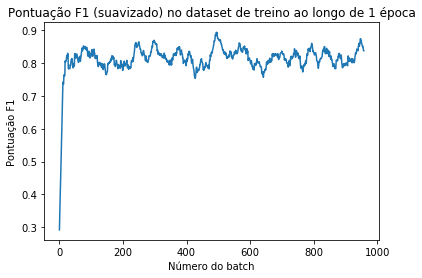

<Figure size 432x288 with 0 Axes>

In [44]:
f1_smooth = smooth(f1_t, 20)
plt.plot(f1_smooth[:-20])
plt.title("Pontuação F1 (suavizado) no dataset de treino ao longo de 1 época")
plt.xlabel("Número do batch")
plt.ylabel("Pontuação F1")

plt.show()
plt.savefig("plot")

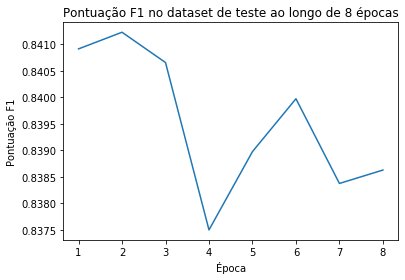

In [30]:
x = range(1,num_epochs+1)
y=f1_e
plt.plot(x, y)
plt.title("Pontuação F1 no dataset de teste ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Pontuação F1")

plt.show()

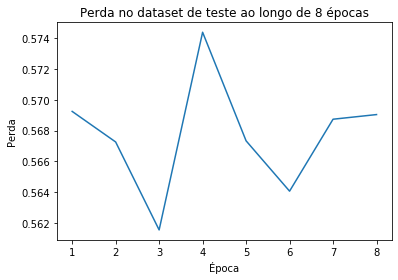

In [31]:
x = range(1,num_epochs+1)
y=losses_e
plt.plot(x, y)
plt.title("Perda no dataset de teste ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.show()

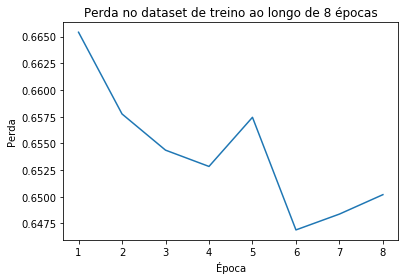

In [32]:
x = range(1,num_epochs+1)
y=losses_t
plt.plot(x, y)
plt.title("Perda no dataset de treino ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.show()

In [21]:
import numpy as np

In [22]:
np.mean(f1_t)

0.8153230375185716

Melhor resultado ali na terceira época? Ainda assim, a mudança de performance é pífia, uma epoca (5 minutos de treino!) já tem um resultado ok. Da pra otimizar a brincadeira, mas a saida não parece ser por epochs. Ainda preciso investigar se o modelo ta com algum problema de aprendizado ou se ele realmente satura muito rapido